[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arcweld/isolation-forest/blob/main/isolation_forest.ipynb 'Open In Colab')  

This notebook and its code are informed and inspired by a 'towards data science' piece written by Adithya Krishnan  
[Anomaly Detection with Isolation Forest & Visualization](https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2)

Intent of exercise is to develop an understanding of using unsupervised learning for anomaly detection. 

### imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit

import os

### read in data
Original TDS piece used a proprietary dataset which the author did not share. Code below is rough (pseudo-code) outline of what was presented in article

In [2]:
# os.listdir('.')

# data_file = './metric_data.csv'
# df = pd.read_csv(data_file)

# df.head()

As a substitute, I will use an alternative multivariate time-series, and see if it will provide functional data within the framework.  
Dataset is the Bike Sharing Demand dataset used by SciKitLearn in the [Time-related feature engineering demo](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py). 

In [74]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame
df

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0000,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0000,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0000,32.0
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0000,13.0
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1.0,12.0,19.0,False,1.0,True,misty,10.66,12.880,0.60,11.0014,119.0
17375,spring,1.0,12.0,20.0,False,1.0,True,misty,10.66,12.880,0.60,11.0014,89.0
17376,spring,1.0,12.0,21.0,False,1.0,True,clear,10.66,12.880,0.60,11.0014,90.0
17377,spring,1.0,12.0,22.0,False,1.0,True,clear,10.66,13.635,0.56,8.9981,61.0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          17379 non-null  float64
 1   month         17379 non-null  float64
 2   hour          17379 non-null  float64
 3   weekday       17379 non-null  float64
 4   temp          17379 non-null  float64
 5   feel_temp     17379 non-null  float64
 6   humidity      17379 non-null  float64
 7   windspeed     17379 non-null  float64
 8   count         17379 non-null  float64
 9   hd            17379 non-null  int64  
 10  wd            17379 non-null  int64  
 11  w_clear       17379 non-null  uint8  
 12  w_heavy_rain  17379 non-null  uint8  
 13  w_misty       17379 non-null  uint8  
 14  w_rain        17379 non-null  uint8  
 15  fall          17379 non-null  uint8  
 16  spring        17379 non-null  uint8  
 17  summer        17379 non-null  uint8  
 18  winter        17379 non-nu

In [76]:
raw_df = df.copy()

### data munging
Next section of code what have been needed for datasets ingested in the format seen by original author. 

In [77]:
"""
# based on metric_data as a time series, with each row of csv 
# reporting one value of one labelled sensor at one timestamp.

# name of column with 
### values: sensor output
### index: timestamp
### columns: sensor label

metrics_df = pd.pivot_table(df, values='', index='', columns='')
metrics_df.reset_index(inplace=True)

# Impute strategy: missing values are set to zero
metrics_df.fillna(0, inplace=True)

metrics_df.head()
"""

"\n# based on metric_data as a time series, with each row of csv \n# reporting one value of one labelled sensor at one timestamp.\n\n# name of column with \n### values: sensor output\n### index: timestamp\n### columns: sensor label\n\nmetrics_df = pd.pivot_table(df, values='', index='', columns='')\nmetrics_df.reset_index(inplace=True)\n\n# Impute strategy: missing values are set to zero\nmetrics_df.fillna(0, inplace=True)\n\nmetrics_df.head()\n"

The time-series I will use does not require this particular re-formatting, but may benefit from some other conditioning. Specifically, I could 
1. encode `holiday` and `workingday`
2. "dummy" encode 'season' and `weather` (using `pandas`' [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html?highlight=get%20dummies) function)  
As all of these columns are categorical, I will keep them and see how they influence the IsolationForest model.  
If I do decide to modify the dataframe, I could use the following code. 


In [78]:
# encode holiday and workday : True -> 1, False -> 0
tf_convert = {'True': 1, 'False': 0}
df['hd'] = df.apply(lambda row: tf_convert[row.holiday] , axis=1)
df['wd'] = df.apply(lambda row: tf_convert[row.workingday] , axis=1)
df.drop(['holiday', 'workingday'], axis=1, inplace=True)

In [79]:
# dummy encode weather (note: will drop categorical 'weather' column)
df = pd.get_dummies(df, prefix='w', prefix_sep='_', dummy_na=False, columns=['weather'], sparse=False, drop_first=False)

In [80]:
# dummy encode season
df = pd.get_dummies(df, prefix='', prefix_sep='', dummy_na=False, columns=['season'], sparse=False, drop_first=False)

Select whether or not to now use the transformed data. A checkmark next to `use_raw_data` abandons all data transformations in above cells, and reverts to original data from `sklearn`'s dataset.  
First walk through of process, I had selected raw data. Upon fitting the model, however, fitting failed and realized model does need to present all numerical data.

In [82]:
#@title Raw or Transformed Data
use_raw_data = False #@param {type:"boolean"}

if use_raw_data:
  metrics_df = raw_df.copy()
else:
  metrics_df = df.copy()

In [83]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          17379 non-null  float64
 1   month         17379 non-null  float64
 2   hour          17379 non-null  float64
 3   weekday       17379 non-null  float64
 4   temp          17379 non-null  float64
 5   feel_temp     17379 non-null  float64
 6   humidity      17379 non-null  float64
 7   windspeed     17379 non-null  float64
 8   count         17379 non-null  float64
 9   hd            17379 non-null  int64  
 10  wd            17379 non-null  int64  
 11  w_clear       17379 non-null  uint8  
 12  w_heavy_rain  17379 non-null  uint8  
 13  w_misty       17379 non-null  uint8  
 14  w_rain        17379 non-null  uint8  
 15  fall          17379 non-null  uint8  
 16  spring        17379 non-null  uint8  
 17  summer        17379 non-null  uint8  
 18  winter        17379 non-nu

### TTS

Using sklearn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) cross-validator

In [84]:
tscv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=10000,
    )

In [85]:
tscv

TimeSeriesSplit(max_train_size=10000, n_splits=5)

In [86]:
tts = list(tscv.split(metrics_df))
metrics_df.iloc[tts[0][0]]

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count,hd,wd,w_clear,w_heavy_rain,w_misty,w_rain,fall,spring,summer,winter
0,0.0,1.0,0.0,6.0,9.84,14.395,0.81,0.0000,16.0,0,0,1,0,0,0,0,1,0,0
1,0.0,1.0,1.0,6.0,9.02,13.635,0.80,0.0000,40.0,0,0,1,0,0,0,0,1,0,0
2,0.0,1.0,2.0,6.0,9.02,13.635,0.80,0.0000,32.0,0,0,1,0,0,0,0,1,0,0
3,0.0,1.0,3.0,6.0,9.84,14.395,0.75,0.0000,13.0,0,0,1,0,0,0,0,1,0,0
4,0.0,1.0,4.0,6.0,9.84,14.395,0.75,0.0000,1.0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,0.0,5.0,12.0,4.0,21.32,25.000,0.34,23.9994,196.0,0,1,1,0,0,0,0,0,1,0
2895,0.0,5.0,13.0,4.0,22.14,25.760,0.30,39.0007,192.0,0,1,1,0,0,0,0,0,1,0
2896,0.0,5.0,14.0,4.0,22.14,25.760,0.28,30.0026,154.0,0,1,1,0,0,0,0,0,1,0
2897,0.0,5.0,15.0,4.0,22.96,26.515,0.26,32.9975,147.0,0,1,1,0,0,0,0,0,1,0


### define IsolationForest model

IsolationForest is a classification model available from `sklearn`. From the dataset, columns are selected as model features. For initial runs, I will present all columns. 

In [87]:
metrics_df.columns

Index(['year', 'month', 'hour', 'weekday', 'temp', 'feel_temp', 'humidity',
       'windspeed', 'count', 'hd', 'wd', 'w_clear', 'w_heavy_rain', 'w_misty',
       'w_rain', 'fall', 'spring', 'summer', 'winter'],
      dtype='object')

In [88]:
to_model_columns = metrics_df.columns
contamination = float(0.01) # NB: setting will require trial and error. 
                            # Value in article was 0.12

clf = IsolationForest(n_estimators=100, max_samples='auto', 
                      contamination=contamination, max_features=1.0, 
                      bootstrap=True, n_jobs=-1, random_state=42,
                      verbose=0 
                      )

First fitting of the model failed, as it is expecting numerical values. Will backtract to above and select processed data with all categorical values encoded. 

In [89]:
clf.fit(metrics_df.iloc[tts[0][0]])

IsolationForest(behaviour='deprecated', bootstrap=True, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

In [90]:
metrics_df['anomaly'] = clf.predict(metrics_df)

In [91]:
outliers = metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index = list(outliers.index)
metrics_df.iloc[outlier_index].describe()

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count,hd,wd,w_clear,w_heavy_rain,w_misty,w_rain,fall,spring,summer,winter,anomaly
count,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.0,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.0
mean,0.620053,7.149077,13.254617,2.345646,26.998338,30.664241,0.620660,12.567600,314.800792,0.381266,0.163588,0.369393,0.0,0.358839,0.271768,0.465699,0.039578,0.328496,0.166227,-1.0
std,0.485694,2.211461,6.267892,2.320274,5.925163,6.357187,0.197311,10.266154,207.409253,0.486018,0.370146,0.482959,0.0,0.479977,0.445165,0.499151,0.195094,0.469976,0.372530,0.0
min,0.000000,1.000000,0.000000,0.000000,3.280000,2.275000,0.160000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
25%,0.000000,5.000000,9.000000,1.000000,25.420000,28.790000,0.450000,6.003200,114.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
50%,1.000000,7.000000,15.000000,1.000000,27.880000,31.820000,0.640000,11.001400,335.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
75%,1.000000,9.000000,18.000000,5.000000,30.340000,34.850000,0.780000,19.001200,476.000000,1.000000,0.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.0
max,1.000000,12.000000,23.000000,6.000000,39.360000,44.695000,1.000000,56.996900,891.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.0


In [92]:
metrics_df.anomaly.value_counts()

 1    16621
-1      758
Name: anomaly, dtype: int64

Not sure what has been classified, but with the model, with the encoded columns, and with an arbitrary "contamination" level of 0.01, we end up with ~5% anomaly.  

Which means...?

## Visualisation
Code taken directly from article (except for matplotlib adaptation to Jupyter nb)

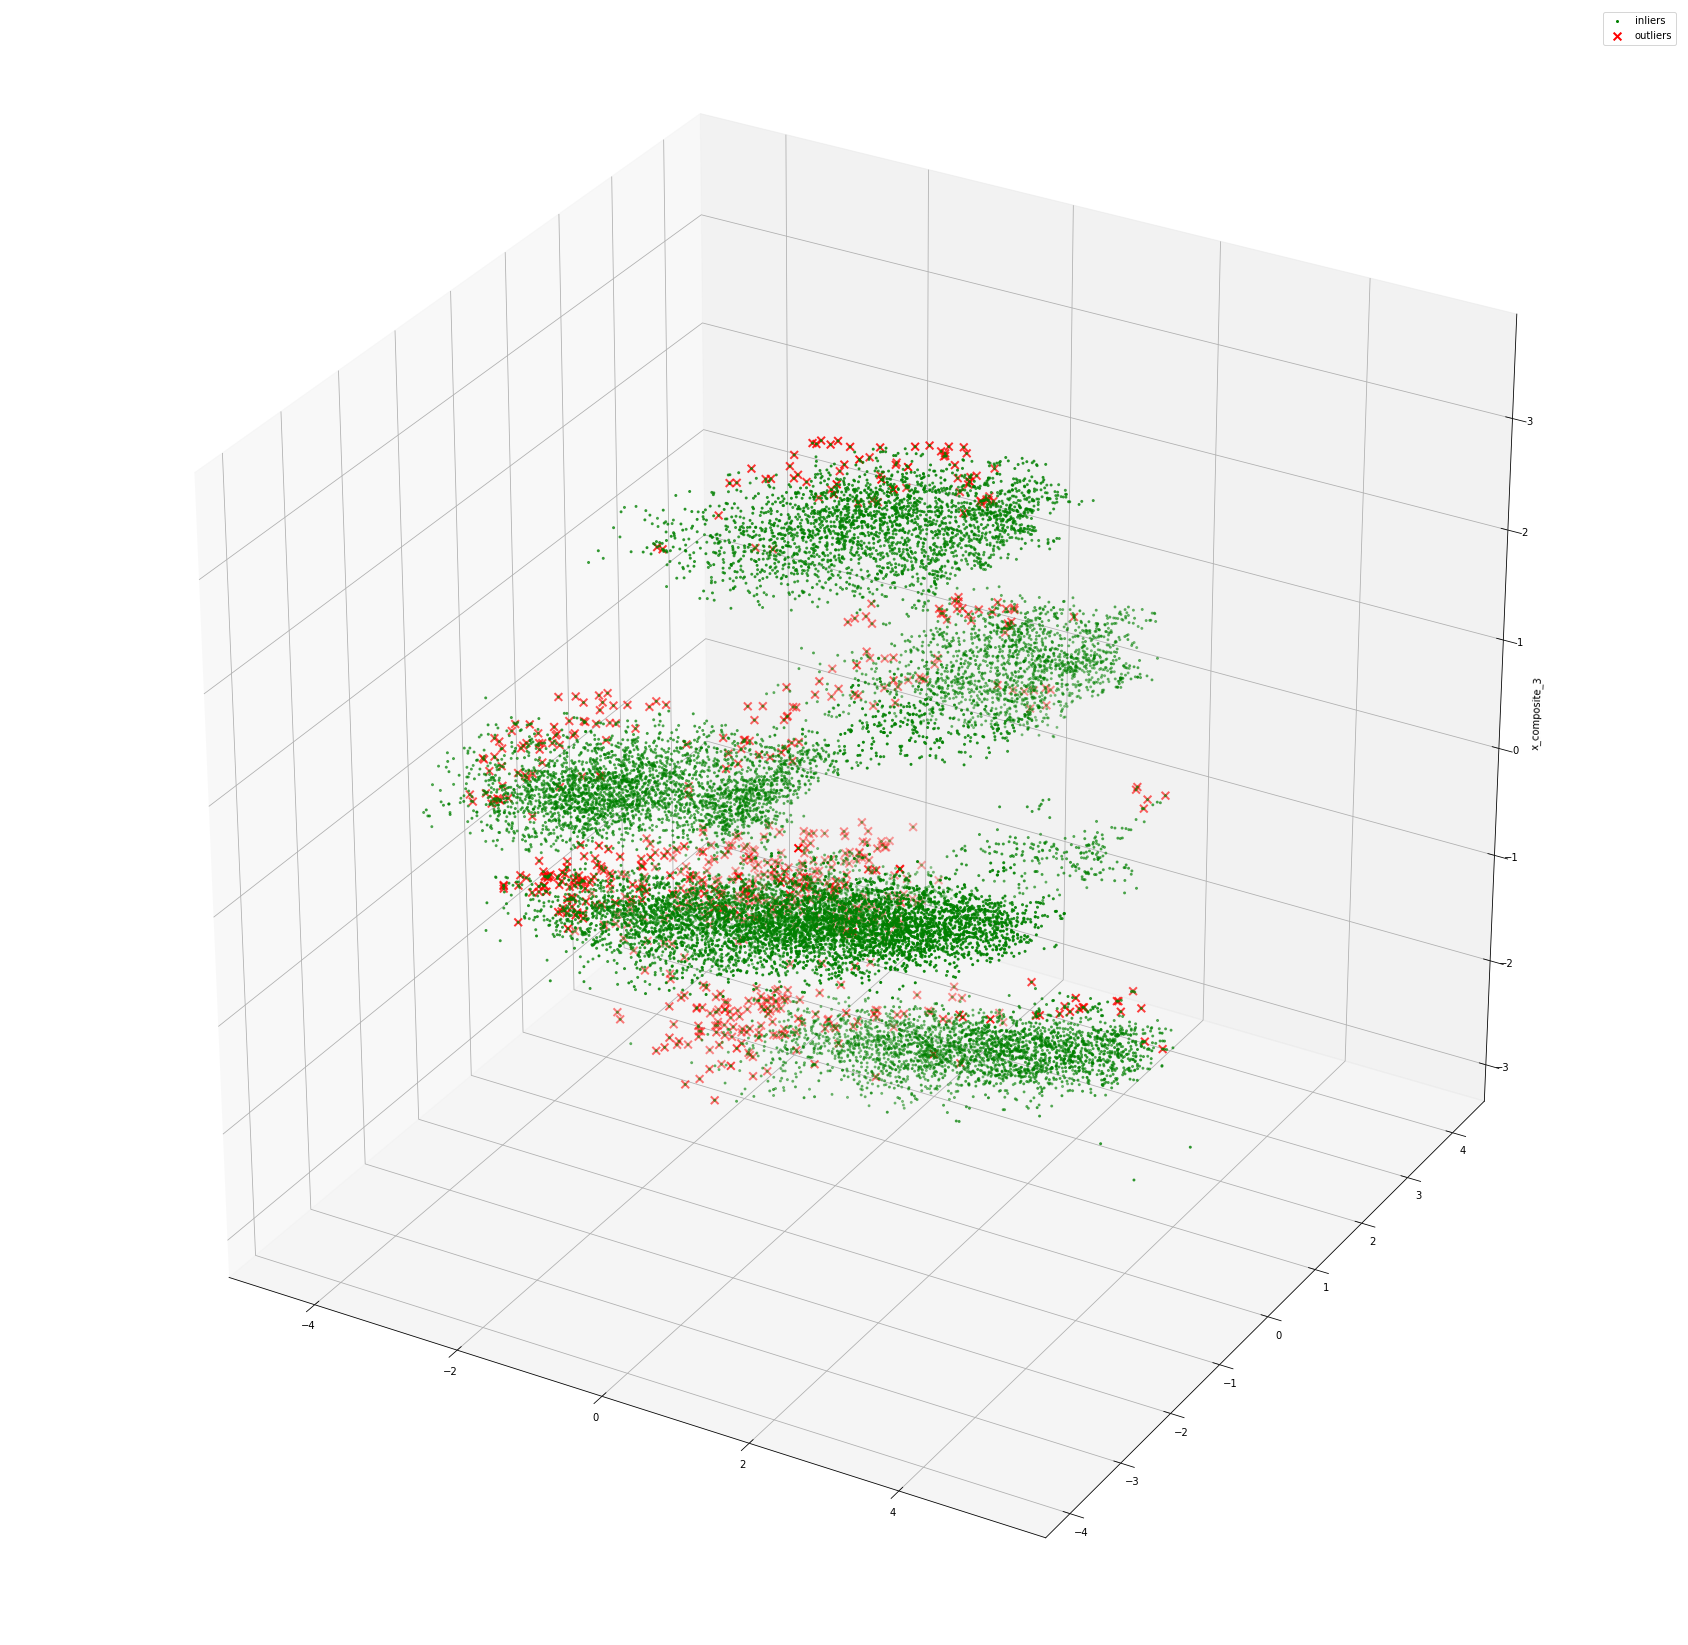

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 30]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

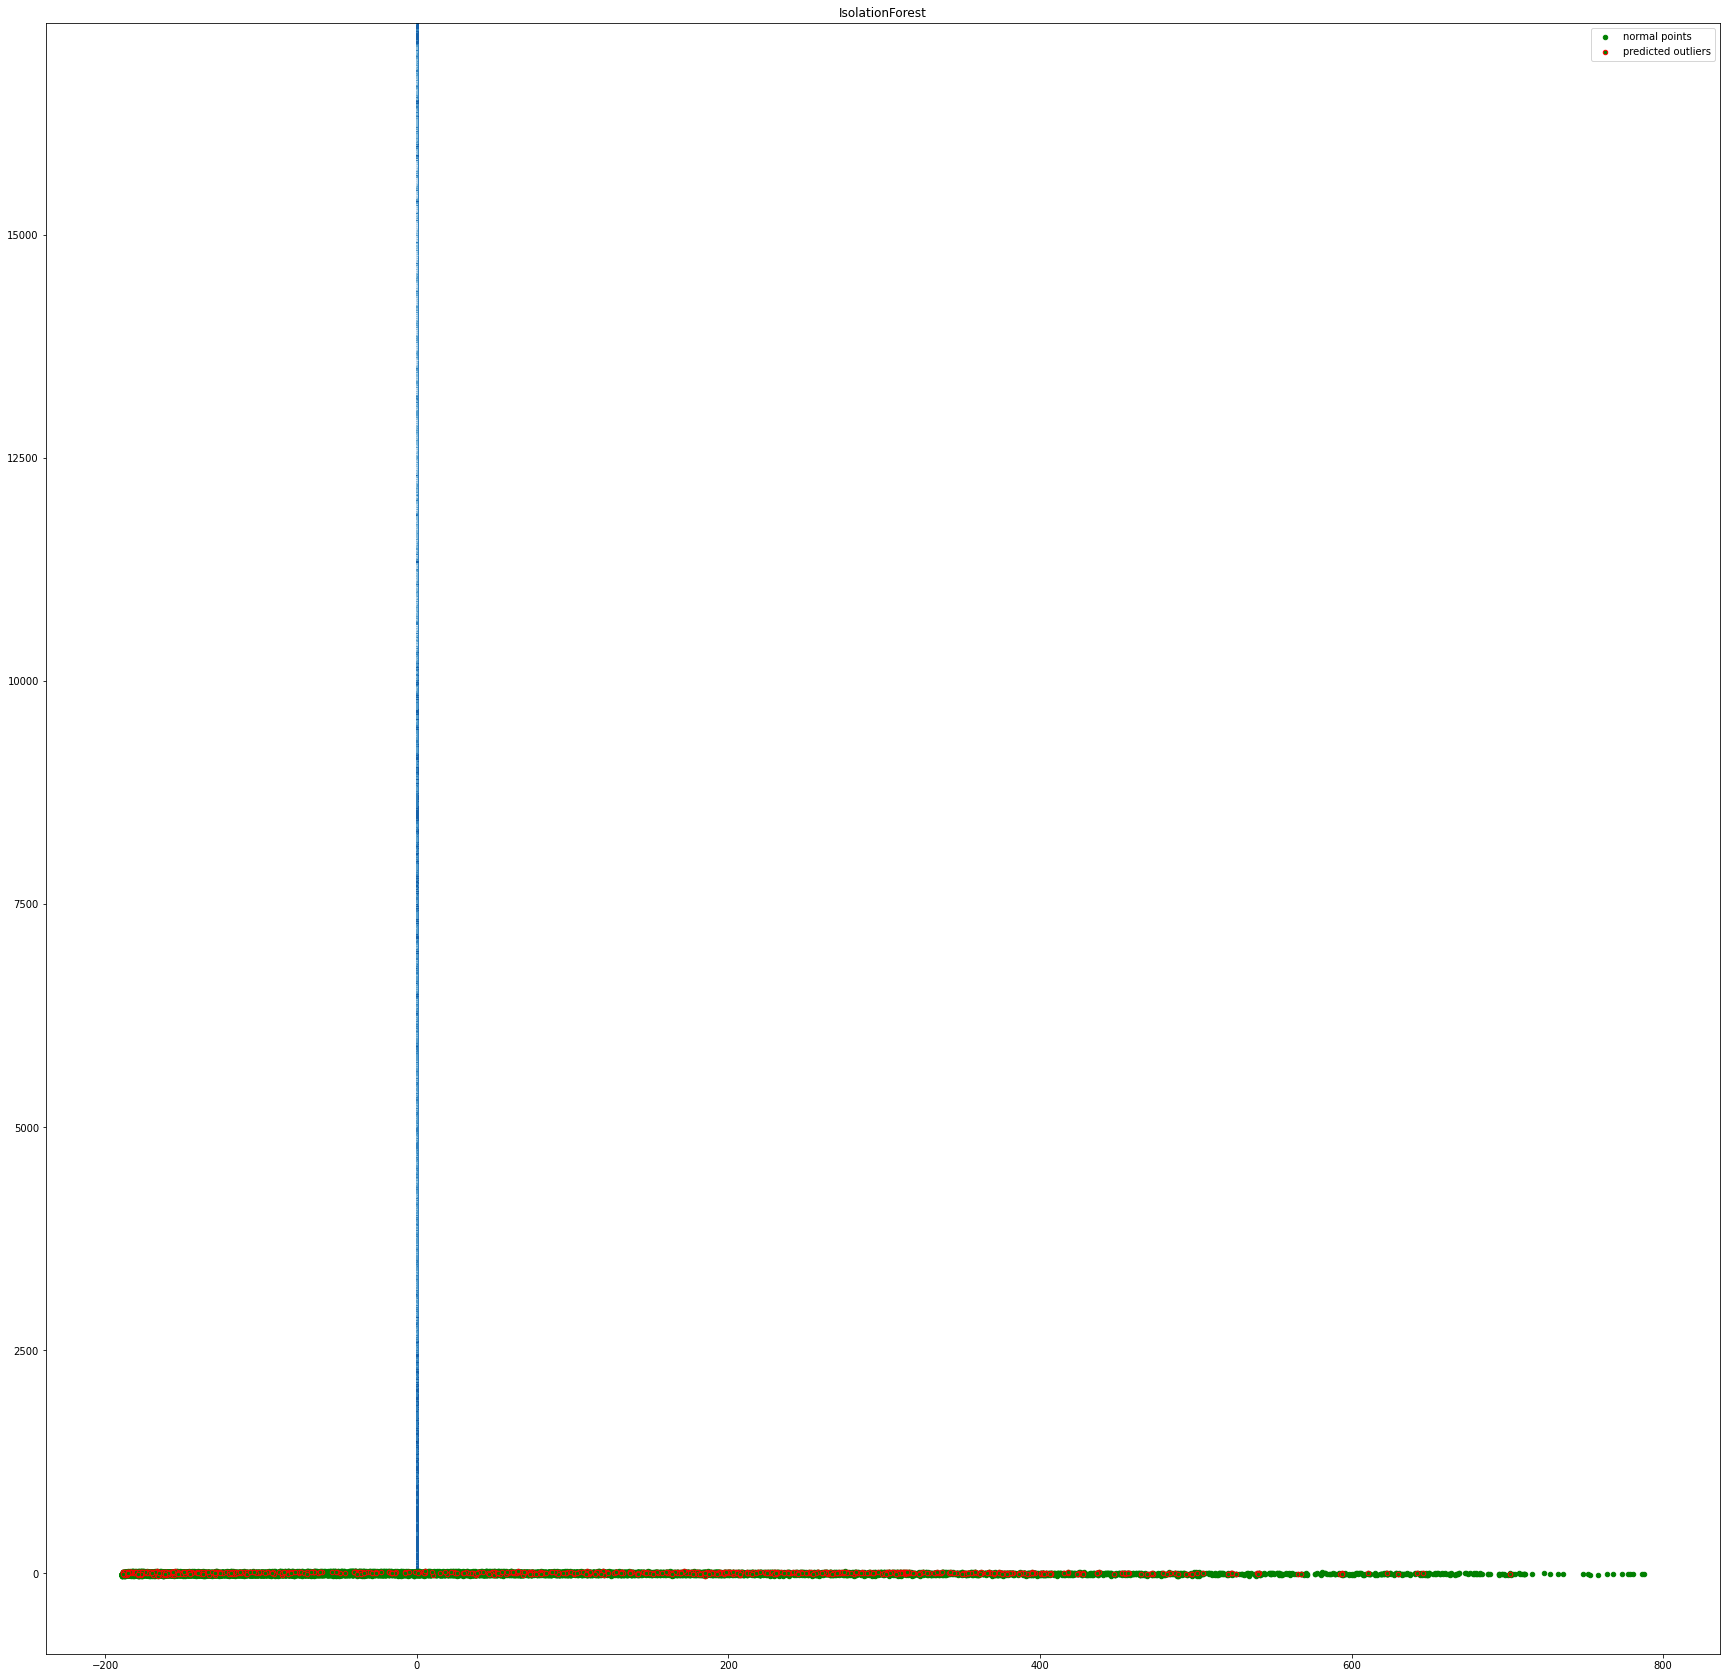

In [100]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(metrics_df[to_model_columns])

res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))

Z = np.array(res)

plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='green', s=20,label="normal points")

b1 = plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20, edgecolor="red", label="predicted outliers")

plt.legend(loc="upper right")
plt.show()

Graphical display of trends, with anomalies marked. 

Problem: author's dataset offers a clear date, but Bike Sharing used here does not have that. Will create a pseudo-data using index.

In [159]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          17379 non-null  float64
 1   month         17379 non-null  float64
 2   hour          17379 non-null  float64
 3   weekday       17379 non-null  float64
 4   temp          17379 non-null  float64
 5   feel_temp     17379 non-null  float64
 6   humidity      17379 non-null  float64
 7   windspeed     17379 non-null  float64
 8   count         17379 non-null  float64
 9   hd            17379 non-null  int64  
 10  wd            17379 non-null  int64  
 11  w_clear       17379 non-null  uint8  
 12  w_heavy_rain  17379 non-null  uint8  
 13  w_misty       17379 non-null  uint8  
 14  w_rain        17379 non-null  uint8  
 15  fall          17379 non-null  uint8  
 16  spring        17379 non-null  uint8  
 17  summer        17379 non-null  uint8  
 18  winter        17379 non-nu

In [161]:
metrics_df.iloc[2]

year            0.000000e+00
month           1.000000e+00
hour            2.000000e+00
weekday         6.000000e+00
temp            9.020000e+00
feel_temp       1.363500e+01
humidity        8.000000e-01
windspeed       0.000000e+00
count           3.200000e+01
hd              0.000000e+00
wd              0.000000e+00
w_clear         1.000000e+00
w_heavy_rain    0.000000e+00
w_misty         0.000000e+00
w_rain          0.000000e+00
fall            0.000000e+00
spring          1.000000e+00
summer          0.000000e+00
winter          0.000000e+00
anomaly         1.000000e+00
index1          2.000000e+00
load_date       2.000010e+07
date            2.000000e+00
Name: 2, dtype: float64

In [156]:
metrics_df['index1'] = metrics_df.index
metrics_df['date'] = metrics_df.apply(lambda row: row['index1'] % 30., axis=1)
metrics_df['load_date'] = metrics_df.apply(lambda row: int(f"{20}{int(row.year):02d}{int(row.month):02d}{int(row.date):02d}"), axis=1)

In [157]:
metrics_df.tail()

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count,hd,wd,w_clear,w_heavy_rain,w_misty,w_rain,fall,spring,summer,winter,anomaly,index1,load_date,date
17374,1.0,12.0,19.0,1.0,10.66,12.880,0.60,11.0014,119.0,0,1,0,0,1,0,0,1,0,0,1,17374,20011204,4.0
17375,1.0,12.0,20.0,1.0,10.66,12.880,0.60,11.0014,89.0,0,1,0,0,1,0,0,1,0,0,1,17375,20011205,5.0
17376,1.0,12.0,21.0,1.0,10.66,12.880,0.60,11.0014,90.0,0,1,1,0,0,0,0,1,0,0,1,17376,20011206,6.0
17377,1.0,12.0,22.0,1.0,10.66,13.635,0.56,8.9981,61.0,0,1,1,0,0,0,0,1,0,0,1,17377,20011207,7.0
17378,1.0,12.0,23.0,1.0,10.66,13.635,0.65,8.9981,49.0,0,1,1,0,0,0,0,1,0,0,1,17378,20011208,8.0


In [133]:
!pip install chart_studio -q

In [186]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
from matplotlib import pyplot
import plotly.graph_objs as go
import plotly.offline as pyo
import IPython

[StackOverflow: Plotly notebook mode with google colaboratory](https://stackoverflow.com/a/54771665/8741130)

In [187]:
def enable_plotly_in_cell():
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

In [192]:
enable_plotly_in_cell()

def plot_anomaly(df,metric_name):
    # df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.load_date
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: 'rgb(228, 222, 249)', 1: "yellow", 2: "red"}
    
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(height=20,
                    values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],
                            ],
                    font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                    fill=dict(color='#d562be')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'percentage_change']],
                   line=dict(color='#506784'),
                   align=['center'] * 5,
                   font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                   # format = [None] + [",.4f"] + [',.4f'],
                   # suffix=[None] * 4,
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[test_df['anomaly_class'].map(color_map)],#map based on anomaly level from dictionary
                   )
                   ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['actuals'],
                         xaxis='x1', yaxis='y1',
                         mode='lines',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))#Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [189]:
def classify_anomalies(df,metric_name):
    df['metric_name']=metric_name
    df = df.sort_values(by='load_date', ascending=False)
    #Shift actuals by one timestamp to find the percentage chage between current and previous data point
    df['shift'] = df['actuals'].shift(-1)
    df['percentage_change'] = ((df['actuals'] - df['shift']) / df['actuals']) * 100
    #Categorise anomalies as 0-no anomaly, 1- low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df

In [190]:
metrics_df.columns

Index(['year', 'month', 'hour', 'weekday', 'temp', 'feel_temp', 'humidity',
       'windspeed', 'count', 'hd', 'wd', 'w_clear', 'w_heavy_rain', 'w_misty',
       'w_rain', 'fall', 'spring', 'summer', 'winter', 'anomaly', 'index1',
       'load_date', 'date'],
      dtype='object')

In [195]:
import warnings  
warnings.filterwarnings('ignore')
enable_plotly_in_cell()

for i in range(3,len(metrics_df.columns)-3):
    clf.fit(metrics_df.iloc[:,i:i+1])
    pred = clf.predict(metrics_df.iloc[:,i:i+1])
    test_df=pd.DataFrame()
    test_df['load_date']=metrics_df['load_date']
    #Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(metrics_df.iloc[:,i:i+1])
    test_df['actuals']=metrics_df.iloc[:,i:i+1]
    test_df['anomaly']=pred
    #Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)
    test_df=classify_anomalies(test_df,metrics_df.columns[i])
    plot_anomaly(test_df,metrics_df.columns[i])

Output hidden; open in https://colab.research.google.com to view.